In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("historical_data.csv")

In [3]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
# convert string datetime columns to datetime objects
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

# create a new column for delivery time in minutes by subtracting the order time from the delivery time
data['delivery_time_minutes'] = (data['actual_delivery_time'] - data['created_at']) / np.timedelta64(1, 'm')

In [5]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,39.833333


In [6]:
# Check for missing values in the dataset
print('Missing values in each column:')
print(data.isnull().sum())

# Let's drop rows with missing values in our key target variable
data = data.dropna(subset=['delivery_time_minutes'])

# Fill missing numeric values with mean values
numeric_cols = data.select_dtypes(include=['float64']).columns
for col in numeric_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

# Fill missing categorical values with the most frequent category
if data['store_primary_category'].isnull().sum() > 0:
    data['store_primary_category'] = data['store_primary_category'].fillna(data['store_primary_category'].mode()[0])

# Verify cleaning results
print('\nRemaining missing values after cleaning:')
print(data.isnull().sum())

Missing values in each column:
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_time_minutes                               7
dtype: int64

Remaining missing values after cleani

## Remove extreme outliers

In [25]:
print(f"rows before outlier removal: {len(data)}")
# Remove extreme outliers (delivery times over 3 hours = 180 minutes)
data = data[data['delivery_time_minutes'] <= 180]
data = data[data['delivery_time_minutes'] > 0]
print(f"Remaining rows after outlier removal: {len(data)}")
print(f"Max delivery time now: {data['delivery_time_minutes'].max()} minutes")
print(f"Min delivery time now: {data['delivery_time_minutes'].min()} minutes")

rows before outlier removal: 197283
Remaining rows after outlier removal: 197283
Max delivery time now: 179.85 minutes
Min delivery time now: 1.6833333333333333 minutes


## Prepare Feature Matrix X and Target Vector y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Define features and target
target = 'delivery_time_minutes'

categorical_features = ['market_id', 'store_id', 'store_primary_category', 'order_protocol']
numeric_features = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'
]

X = data[categorical_features + numeric_features]
y = data[target]

# Step 2: Build preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Step 3: Apply transformation
X_processed = preprocessor.fit_transform(X)

preprocessor.fit(X)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


## Define and Train a Neural Network in PyTorch


1. Setup: PyTorch Dataset & DataLoader

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


 2. Define the Neural Network

In [23]:
import torch.nn as nn

class ETARegressor(nn.Module):
    def __init__(self, input_dim):
        super(ETARegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


3. Train the Model

In [24]:
# Initialize model, loss, and optimizer
input_dim = X_train_tensor.shape[1]
model = ETARegressor(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")


Epoch [1/20] - Loss: 319.5651
Epoch [2/20] - Loss: 238.7751
Epoch [3/20] - Loss: 231.4087
Epoch [4/20] - Loss: 227.1532
Epoch [5/20] - Loss: 224.0047
Epoch [6/20] - Loss: 221.1608
Epoch [7/20] - Loss: 218.7923
Epoch [8/20] - Loss: 216.7582
Epoch [9/20] - Loss: 214.2989
Epoch [10/20] - Loss: 212.4682
Epoch [11/20] - Loss: 210.6287
Epoch [12/20] - Loss: 209.0477
Epoch [13/20] - Loss: 207.1027
Epoch [14/20] - Loss: 205.9443
Epoch [15/20] - Loss: 204.4874
Epoch [16/20] - Loss: 203.2091
Epoch [17/20] - Loss: 201.7955
Epoch [18/20] - Loss: 200.3336
Epoch [19/20] - Loss: 198.9808
Epoch [20/20] - Loss: 197.7422


4. Evaluate on Test Set (R² and MSE)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()
    y_true = y_test_tensor.squeeze().numpy()

mse = mean_squared_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f"\nTest MSE: {mse:.2f}")
print(f"Test R²: {r2:.4f}")



Test MSE: 231.60
Test R²: 0.2822


## visualization

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


1. Histogram of Delivery Times

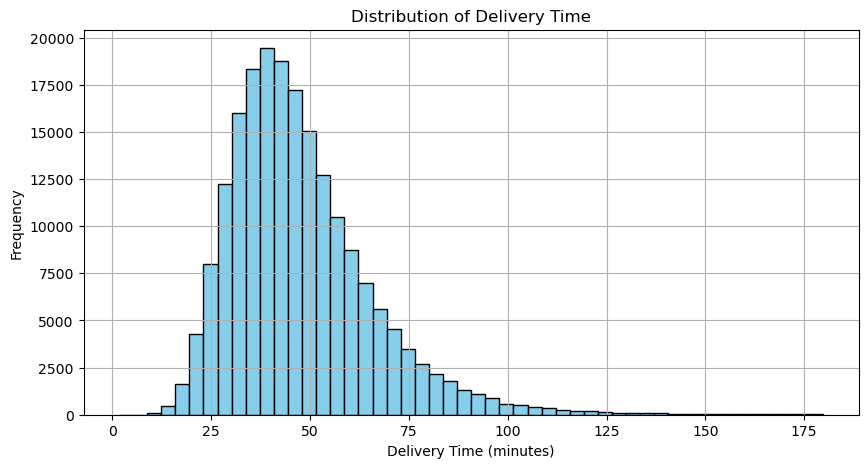

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(data['delivery_time_minutes'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


2. Heat Map

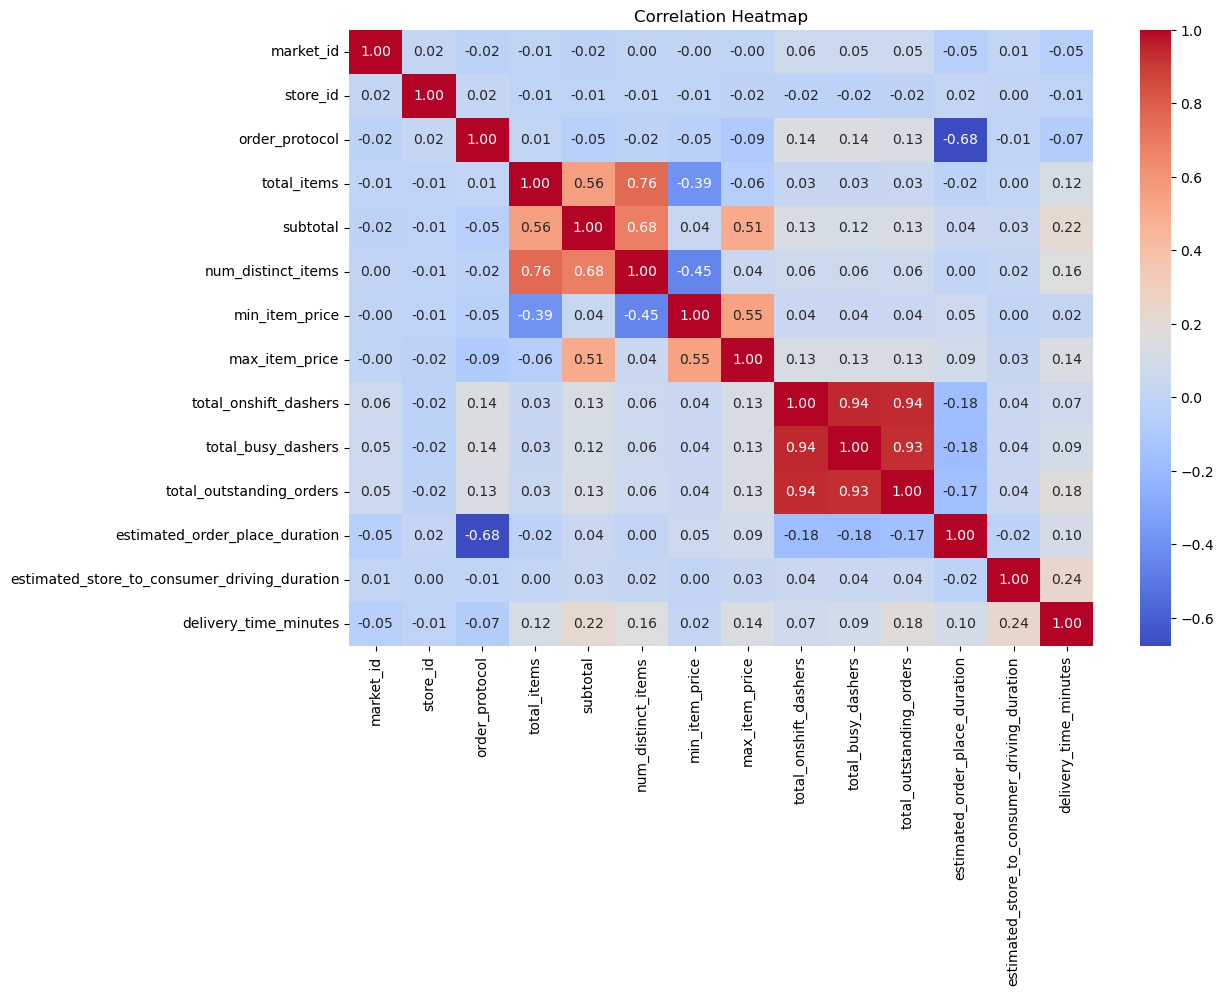

In [33]:
plt.figure(figsize=(12, 8))
corr = data.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


## Permutation Importance for  NN model

1. Create the PyTorch Wrapper:

In [35]:
from sklearn.base import BaseEstimator

class PyTorchWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y): pass  # Not used

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            return self.model(X_tensor).squeeze().numpy()



2. Run Permutation Importance:

In [36]:
from sklearn.inspection import permutation_importance

wrapped_model = PyTorchWrapper(model)

result = permutation_importance(
    wrapped_model,
    X_test.toarray(),  # if it's sparse
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)


KeyboardInterrupt: 

3. Plot the Importance:

In [ ]:
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 15 Most Important Features (Permutation Importance)')
plt.xlabel('Importance (Avg. Impact on MSE)')
plt.tight_layout()
plt.show()
